<a href="https://colab.research.google.com/github/Swathieluri31/FMML_LAB_MODULES/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 05:08:37--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.71, 18.160.200.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   204MB/s    in 0.2s    

2024-05-14 05:08:37 (204 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


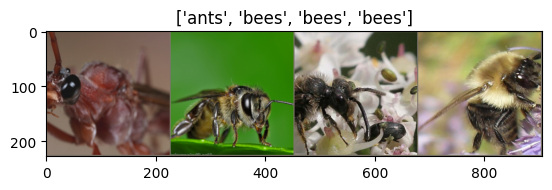

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.7MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.4815 Acc: 0.7418

Epoch 1/4
----------
Loss: 0.4899 Acc: 0.7910

Epoch 2/4
----------
Loss: 0.4611 Acc: 0.8320

Epoch 3/4
----------
Loss: 0.4160 Acc: 0.8361

Epoch 4/4
----------
Loss: 0.4273 Acc: 0.8484



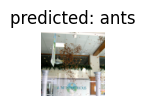

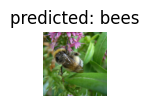

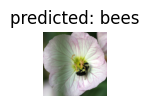

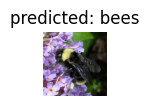

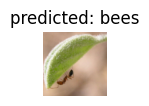

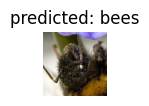

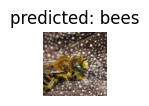

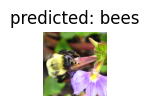

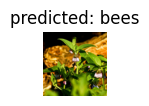

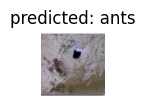

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


** 1ST QUESTION ANSWER**

Data augmentation is a technique used to artificially increase the size and diversity of a training dataset in machine learning, particularly in computer vision tasks. Here's why it's significant:

Reduces Overfitting: Machine learning models can learn patterns from the training data too well, leading to overfitting. Overfitting makes the model perform well on the training data but poorly on unseen data. Data augmentation helps by creating variations of existing data points, forcing the model to learn more generalizable features.

Improves Generalizability: By training on a wider range of variations, the model becomes more robust to small changes in the input data. This improves the model's ability to perform well on new data that it hasn't seen before.

Addresses Class Imbalance: In some datasets, certain classes might have significantly fewer data points compared to others. Data augmentation can help balance the dataset by generating more examples for under-represented classes.

Techniques like resize and crop achieve this by modifying the data in ways that reflect real-world variations. For instance, an image classifier might encounter objects at different scales or positions in real life. By resizing and cropping the training images, the model learns these variations and becomes more adaptable.

Here are some other common data augmentation techniques:

Flipping: Flipping images horizontally or vertically introduces variations that the model might encounter in the real world (e.g., a face looking left or right).
Rotation: Rotating images slightly helps the model learn features that are independent of orientation.
Color Space Adjustments: Modifying brightness, contrast, or saturation helps the model be less sensitive to lighting variations.

pen_spark


**2ND QUESTION ANSWER**

When you train a ResNet model from scratch (without pre-trained weights), you can expect significantly lower performance compared to using a pre-trained model. Here's why:

Random Initialization: The weights of the network are initialized with random values. These random weights might not capture any meaningful features from the data initially.
Learning from Scratch: The model needs to learn all the features necessary for the task from the training data itself. This requires a much larger dataset and significantly longer training time compared to fine-tuning a pre-trained model.
Local Minima: Training from scratch is more prone to getting stuck in local minima, which are suboptimal solutions that can lead to poor performance.
The exact performance drop depends on several factors, including:

Dataset Size: With a very large dataset, the model might eventually learn good features. However, this can be computationally expensive and time-consuming.
ResNet Variant: Deeper ResNet variants (e.g., ResNet-152) might show slightly better performance compared to shallower ones (e.g., ResNet-18) when trained from scratch, but the gap will still be significant compared to pre-trained models.
Task Complexity: For simpler tasks with easily distinguishable features, the performance drop might be less severe. However, for complex tasks with subtle variations, the accuracy will likely be much lower.
In some cases, you might see accuracy starting in the random guess range (around 10% for tasks with 10 classes) and slowly improving as training progresses. It can take many epochs (iterations over the entire dataset) to reach a decent level of performance, which might still be far below what a pre-trained model could achieve.

Therefore, using pre-trained weights is the standard practice for ResNet models. The pre-trained weights act as a good starting point, with the lower layers already capturing generic image features. Fine-tuning these weights on your specific dataset allows the model to learn task-specific features much faster and achieve significantly better performance.

pen_spark




tune

share


more_vert


**3RD QUESTION ANSWER**

The performance of a pre-trained ResNet model on an ants vs. bees dataset depends on how significantly different the pre-training dataset is from images of ants and bees. Here's a breakdown:

Significant Difference:

Lower Performance: If the pre-trained dataset is very different from images of insects (e.g., everyday objects, landscapes), the performance will likely be lower than using a model pre-trained on a more relevant dataset. The lower layers of the pre-trained model might not capture features useful for distinguishing ants from bees.
Transfer Learning with Caution: Transfer learning (using a pre-trained model as a starting point) can still be beneficial, but you might need to:
Freeze More Layers: During fine-tuning, consider freezing a larger number of the pre-trained layers to prevent the model from forgetting the general image features it learned.
More Training Data: You might need a larger dataset of ant and bee images to compensate for the less relevant pre-training.
Somewhat Similar Dataset:

Decent Performance: If the pre-trained dataset includes some categories visually similar to insects (e.g., animals, other small creatures), the model might still achieve decent performance. The pre-trained model can leverage its knowledge of edges, shapes, and textures to some extent.
Ideally:

Pre-trained on Insect Dataset: The best performance would be achieved by using a ResNet model pre-trained on a dataset specifically containing insects or even closer still, a dataset with ants and bees. This pre-training would provide the most relevant foundation for the model to learn the specific features needed to distinguish between ants and bees.
In conclusion, using a pre-trained ResNet model can still be a good starting point even for a dataset like ants vs. bees, but the effectiveness depends on the relevance of the pre-training data. The more similar the pre-training data is to your specific task, the better the initial performance and the easier it will be to fine-tune the model for good accuracy.

pen_spark




tune

share


more_vert
